In [1]:
using CSV
using DataFrames
using PyPlot
using StatsBase # Statistics
using Formatting # string formatting
using ScikitLearn # machine learning package
using ScikitLearn.CrossValidation: train_test_split
@sk_import gaussian_process : GaussianProcessRegressor
@sk_import gaussian_process.kernels : Matern

@sk_import inspection : permutation_importance

PyObject <function permutation_importance at 0x7f16126ef8c8>

In [2]:
# load descriptor data
filename = joinpath(pwd(), "descriptors/cof_descriptors.csv")
descriptors = CSV.read(filename, DataFrame)
rename!(descriptors, "crystal_name" => "xtal")

# WARNING: for these "⟨N⟩ (mmol/g)" = [0.0, 0.0] producing sel = NaN... remove them from dataset
skip_for_now = ["13030N2_ddec.cif", "16371N2_ddec.cif", "20565N3_ddec.cif", "21090N3_ddec.cif"]
filter!(row -> ! (row["xtal"] in skip_for_now), descriptors)

# load target data
target_data = CSV.read(joinpath(pwd(), "target_and_cost_data.csv"), DataFrame)
target_data[1:5, :]

,xtal,henry_selectivity,gcmc_selectivity
,String,Float64,Float64
1,05000N2_ddec.cif,1.58051,1.69624
2,05001N2_ddec.cif,3.27135,3.2725
3,07000N2_ddec.cif,2.9979,2.99372
4,07001N2_ddec.cif,9.01379,9.65039
5,07002N2_ddec.cif,3.60253,3.64401


Scikitlearn takes as input:

- a feature matrix X, which must be n_samples by n_features
- a target vector y, which must be n_samples long (of course)

In [3]:
###
#  construct feature matrix and target vector for GP
###
x_cols = [name for name in names(descriptors) if name != "xtal"]
n_xtals = nrow(descriptors)

X = zeros(n_xtals, length(x_cols))
henry_y = zeros(n_xtals)
gcmc_y  = zeros(n_xtals)

for (i, row) in enumerate(eachrow(descriptors))   
    for (j, col_name) in enumerate(x_cols)
        X[i, j] = row[col_name]
    end
    # Xe/Kr Selectivity
    henry_y[i] = target_data[i, :henry_selectivity] 
    gcmc_y[i]  = target_data[i, :gcmc_selectivity]
end
X # look at y too!

608×14 Matrix{Float64}:
  3.84928  0.2  4175.64  1049.37   0.0292303   …  0.00974344   0.0  0.0  0.0
 19.7302   0.6  3156.96   585.477  0.0204808      0.00227564   0.0  0.0  0.0
 26.1625   0.8  3407.23   458.054  0.0171524      0.00142936   0.0  0.0  0.0
  7.82083  0.4  2565.59  1100.22   0.037349       0.00466863   0.0  0.0  0.0
 14.8469   0.4  3345.75   703.114  0.0271906      0.00194218   0.0  0.0  0.0
  9.33026  0.7  5261.66   421.68   0.0149858   …  0.00239773   0.0  0.0  0.0
  9.94867  0.7  5452.36   383.117  0.0125929      0.00209882   0.0  0.0  0.0
 18.946    0.9  5335.37   180.981  0.00653913     0.000544927  0.0  0.0  0.0
 27.193    0.9  5190.06   171.075  0.00643935     0.000525661  0.0  0.0  0.0
 10.0414   0.6  5593.85   519.979  0.0156241      0.00175223   0.0  0.0  0.0
  4.7838   0.2  3845.42  1143.15   0.0374755   …  0.00468444   0.0  0.0  0.0
  7.51918  0.4  3597.55   988.327  0.0313415      0.00447735   0.0  0.0  0.0
  9.8332   0.5  3440.67   874.7    0.0265802      0.

In [4]:
# Normalize the feature vectors
for j in 1:length(x_cols)
    X[:, j] = (X[:, j] .- minimum(X[:, j])) / (maximum(X[:, j]) - minimum(X[:, j]))
end
println(minimum(X[:, 2]))
println(maximum(X[:, 2]))

0.0
1.0


In [5]:
###
#  Spit data into training and testing sets
###
henry_X_train, henry_X_test, henry_y_train, henry_y_test = train_test_split(X, henry_y, test_size=0.4)

gcmc_X_train, gcmc_X_test, gcmc_y_train, gcmc_y_test = train_test_split(X, gcmc_y, test_size=0.4)

###
#  Construct GP 
###
henry_kernel = Matern(nu=2.5, length_scale=0.25) 
henry_gpr = GaussianProcessRegressor(kernel=henry_kernel, normalize_y=true, n_restarts_optimizer=5)

gcmc_kernel = Matern(nu=2.5, length_scale=0.25) 
gcmc_gpr  = GaussianProcessRegressor(kernel=gcmc_kernel, normalize_y=true, n_restarts_optimizer=5)

###
#  Train GP on data 
###
henry_gpr.fit(henry_X_train, henry_y_train)
println("Henry - post fit kernel:\t", henry_gpr.kernel_)

gcmc_gpr.fit(gcmc_X_train, gcmc_y_train)
println("GCMC - post fit kernel:\t", gcmc_gpr.kernel_)

###
#  predictions on test data using trained GP
###
henry_y_pred, henry_y_std = henry_gpr.predict(henry_X_test, return_std=true, return_cov=false)

gcmc_y_pred, gcmc_y_std = gcmc_gpr.predict(gcmc_X_test, return_std=true, return_cov=false);

###
#  Compute statistics about the fit - 
#      RMSE, R2, and Spearman rank
###
henry_rmse = sqrt(mean((henry_y_test - henry_y_pred).^2))
henry_r2 = henry_gpr.score(henry_X_test, henry_y_test)
henry_corspearman = corspearman(henry_y_test, henry_y_pred)

gcmc_rmse = sqrt(mean((gcmc_y_test - gcmc_y_pred).^2))
gcmc_r2 = gcmc_gpr.score(gcmc_X_test, gcmc_y_test)
gcmc_corspearman = corspearman(gcmc_y_test, gcmc_y_pred);

Henry - post fit kernel:	PyObject Matern(length_scale=0.15, nu=2.5)
GCMC - post fit kernel:	PyObject Matern(length_scale=0.188, nu=2.5)


# Parity Plots

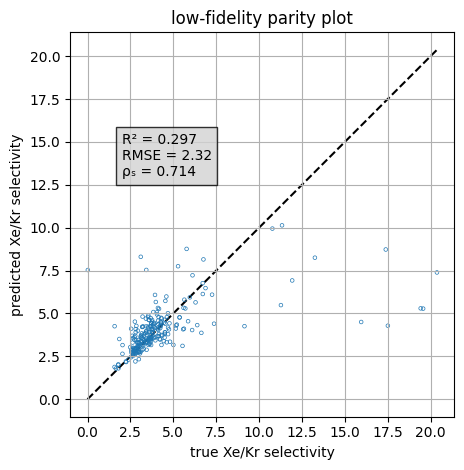

In [6]:
figure()

xmax = maximum(max.(henry_y_test, henry_y_pred))
x = range(0.0, stop=xmax, length=length(henry_y_test))
y = x
plot(x, y, color="k", linestyle="--", zorder=0)

scatter(henry_y_test, henry_y_pred, facecolor="none", edgecolor="C0", linewidth=0.5, s=7)

str = format("R² = {:0.3f}\nRMSE = {:0.2f}\nρₛ = {:0.3f}", henry_r2, henry_rmse, henry_corspearman)
box_styl = Dict(:facecolor => "lightgrey", :alpha => 0.8)
text(2, 13, str, color="k", bbox=box_styl)

grid("on")
gca().set_aspect("equal", adjustable="box")

title("low-fidelity parity plot")
xlabel("true Xe/Kr selectivity")
ylabel("predicted Xe/Kr selectivity")

tight_layout()
# savefig(joinpath(pwd(), "henry_selectivity_parity_plot.png"), dpi=600, format="png")

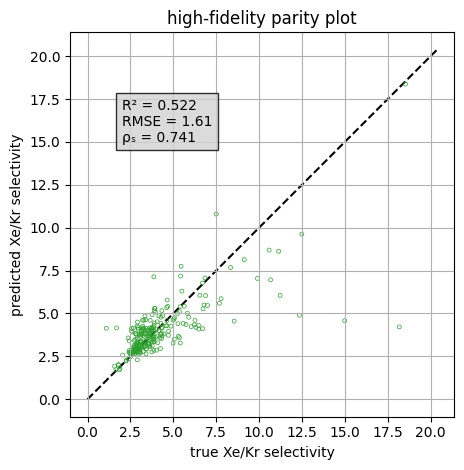

In [7]:
fig = figure()

xmin = minimum(min.(gcmc_y_test, gcmc_y_pred))
# xmax = maximum(max.(gcmc_y_test, gcmc_y_pred))
x = range(0.0, stop=xmax, length=length(gcmc_y_test))
y = x
plot(x, y, color="k", linestyle="--", zorder=0)

scatter(gcmc_y_test, gcmc_y_pred, facecolor="none", edgecolor="C2", s=8, linewidth=0.5)

str = format("R² = {:0.3f}\nRMSE = {:0.2f}\nρₛ = {:0.3f}", gcmc_r2, gcmc_rmse, gcmc_corspearman)
box_styl = Dict(:facecolor => "lightgrey", :alpha => 0.8)
plt = text(2, 15, str, color="k", bbox=box_styl)


grid("on")
gca().set_aspect("equal", adjustable="box")

title("high-fidelity parity plot")
xlabel("true Xe/Kr selectivity")
ylabel("predicted Xe/Kr selectivity")

tight_layout()
# savefig(joinpath(pwd(), "gcmc_selectivity_parity_plot.png"), dpi=600, format="png")